In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import glob
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [8]:
actions_label_set = ["Brush_teeth", "Climb_stairs", "Comb_hair", "Descend_stairs", "Drink_glass", "Eat_meat", 
                     "Eat_soup", "Liedown_bed", "Pour_water", "Sitdown_chair", "Walk", "Use_telephone", 
                     "Standup_chair", "Getup_bed"]
label_to_data_training = {}
label_to_data_validation = {}
label_to_data_testing = {}

df_training = pd.DataFrame(columns=["x", "y", "z"])
for label in actions_label_set:
    files = glob.glob("/Users/18219/Desktop/data/training/" + label + "/*txt")
    data = []
    for file_name in files:
        df_temp = pd.read_csv(file_name, sep=" ", header=None, names=["x", "y", "z"])
        df_training = df_training.append(df_temp, ignore_index=True)
        data.append(np.array(df_temp))
    label_to_data_training[label] = data


df_validation = pd.DataFrame(columns=["x", "y", "z"])
for label in actions_label_set:
    files = glob.glob("/Users/18219/Desktop/data/validation/" + label + "/*txt")
    data = []
    for file_name in files:
        df_temp = pd.read_csv(file_name, sep=" ", header=None, names=["x", "y", "z"])
        df_validation = df_validation.append(df_temp, ignore_index=True)
        data.append(np.array(df_temp))
    label_to_data_validation[label] = data

df_testing = pd.DataFrame(columns=["x", "y", "z"])
for label in actions_label_set:
    files = glob.glob("/Users/18219/Desktop/data/testing/" + label + "/*txt")
    data = []
    for file_name in files:
        df_temp = pd.read_csv(file_name, sep=" ", header=None, names=["x", "y", "z"])
        df_testing = df_testing.append(df_temp, ignore_index=True)
        data.append(np.array(df_temp))
    label_to_data_testing[label] = data


         x   y   z
0       16  45  34
1       16  45  33
2       16  44  35
3       16  46  36
4       15  44  36
5       14  44  35
6       14  44  36
7       15  45  36
8       14  43  36
9       14  44  37
10      15  44  37
11      15  43  36
12      16  45  35
13      15  44  36
14      14  44  36
15      14  43  36
16      16  45  36
17      16  44  36
18      14  44  36
19      14  44  37
20      13  45  37
21      15  46  37
22      12  47  38
23      14  49  38
24      15  48  38
25      17  49  39
26      18  51  38
27      22  50  41
28      25  51  41
29      27  50  40
...     ..  ..  ..
341419  12  33  36
341420  13  33  34
341421  12  32  37
341422  13  32  36
341423  11  32  35
341424  12  33  36
341425  12  33  36
341426  11  32  36
341427  12  33  36
341428  12  32  36
341429  12  32  36
341430  13  31  35
341431  11  32  36
341432  12  32  36
341433  13  32  36
341434  12  32  36
341435  12  32  35
341436  13  33  35
341437  13  32  37
341438  12  32  34
341439  10  

In [13]:
#partition data into d parts
def train_kmeans_model(segment_length, num_of_clusters, df):
    partitioned_vectors = []
    num_of_parts = int(len(df)/segment_length)
    df_updated = np.array(df[0:(segment_length * num_of_parts)])

    training_examples = np.split(df_updated, num_of_parts)
    for training_example in training_examples:
        reshaped_vector = np.reshape(training_example, (1, (segment_length * 3)))
        partitioned_vectors.append(reshaped_vector[0])

    kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(partitioned_vectors)
    return kmeans



In [20]:


def obtain_feature_vectors(segment_length, kmeans, label_to_data):
    class_labels = []
    feature_vectors = []
    training_examples = {}
    label_to_class = dict(zip(actions_label_set, range(0,len(actions_label_set))))
    
    for label in actions_label_set:
        all_file_data = label_to_data[label]
        for file_data in all_file_data:
            feature_vector = get_feature_vector(file_data, segment_length, kmeans)
            feature_vectors.append(feature_vector)
            class_labels.append(label_to_class[label])
    training_examples[0] = feature_vectors
    training_examples[1] = class_labels
    return training_examples
    
def get_feature_vector(raw_data, segment_length, kmeans):
    parts = int(len(raw_data)/segment_length)
    data = np.split(raw_data[0:(segment_length * parts)], parts)
    training_examples = []
    for data_item in data:
        sliced_data = np.reshape(data_item, (1, (segment_length * 3)))
        training_examples.append(sliced_data[0])
    cluster_count = kmeans.predict(training_examples)
    return get_cluster_histogram(cluster_count)

def get_cluster_histogram(cluster_count):
    features = [0 for i in range(400)]
    cluster_count_histogram = dict(Counter(cluster_count))
    for key, value in cluster_count_histogram.items():
        features[key] = value
    return features



In [85]:
def calculate_accuracy(d, k, df_training):
    kmeans = train_kmeans_model(d, k, df_training)
    training = obtain_feature_vectors(d, kmeans, label_to_data_training)
    validation = obtain_feature_vectors(d, kmeans, label_to_data_validation)
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(training[0], training[1])
    classified_labels = classifier.predict(validation[0])
    accuracy = metrics.accuracy_score(validation[1], classified_labels)
    return accuracy

d_lower = d_values_range[0]
d_upper = d_values_range[1]

def find_d_range(d_lower, d_upper, k, iterations):
    i = 0
    while (i < iterations):
        acc_lower = calculate_accuracy(d_lower, k, df_training)
        acc_upper = calculate_accuracy(d_upper, k, df_training)
        if acc_upper > acc_lower:
            d_lower = int((d_upper + d_lower)/2)
        else:
            d_upper = int((d_upper + d_lower)/2)
        i = i + 1
    return (d_lower, d_upper)

def find_k_range(k_lower, k_upper, d, iterations):
    i = 0
    while (i < iterations):
        acc_lower = calculate_accuracy(d, k_lower, df_training)
        acc_upper = calculate_accuracy(d, k_upper, df_training)
        if acc_upper > acc_lower:
            k_lower = int((k_upper + k_lower)/2)
        else:
            k_upper = int((k_upper + k_lower)/2)
        i = i + 1
    return (k_lower, k_upper)

def get_optimal_k():
    k_d_graph_values = {}
    d_values = [5, 15, 25, 50]
    for d in d_values:
        k_range = find_k_range(50, 300, d, 4)
        overall_accuracy = calculate_accuracy(d, int((k_range[0] + k_range[1])/2), df_training)
        k_d_graph_values[(int((k_range[0] + k_range[1])/2), d)] = overall_accuracy
    return k_d_graph_values

def get_optimal_d():
    k_d_graph_values = {}
    k_values = [40, 80, 120, 200]
    for k in k_values:
        d_range = find_d_range(5, 40, k, 4)
        overall_accuracy = calculate_accuracy(int((d_range[0] + d_range[1])/2), k, df_training)
        k_d_graph_values[k, (int((d_range[0] + d_range[1])/2))] = overall_accuracy
    return k_d_graph_values

points_d = get_optimal_d()
points_k = get_optimal_k()

300
300
300
300
{(40, 6): 0.7528089887640449, (80, 8): 0.7528089887640449, (200, 10): 0.7865168539325843, (120, 38): 0.7640449438202247}
{(73, 50): 0.7078651685393258, (119, 5): 0.8089887640449438, (167, 25): 0.7865168539325843, (57, 15): 0.7640449438202247}


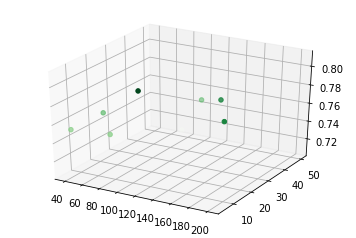

In [86]:
ax = plt.axes(projection='3d')
x_data = []
y_data = []
z_data = []

for key, value in points_d.items():
    x_data.append(key[0])
    y_data.append(key[1])
    z_data.append(value)
    
for key, value in points_k.items():
    x_data.append(key[0])
    y_data.append(key[1])
    z_data.append(value)

ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens');

In [94]:
d, k = 6, 40

kmeans = train_kmeans_model(d, k, df_training)
training = obtain_feature_vectors(d, kmeans, label_to_data_training)
validation = obtain_feature_vectors(d, kmeans, label_to_data_validation)
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(training[0], training[1])
classified_labels = classifier.predict(validation[0])
accuracy = metrics.accuracy_score(validation[1], classified_labels)
print accuracy

0.775280898876


In [93]:
d, k = 7, 57
testing = obtain_feature_vectors(d, kmeans, label_to_data_testing)
classified_labels = classifier.predict(testing[0])
accuracy = metrics.accuracy_score(testing[1], classified_labels)
print metrics.confusion_matrix(testing[1], classified_labels)
print accuracy

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 9 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 6 0]
 [0 2 0 0 0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 3 0 0 3 1]
 [0 1 0 0 0 0 0 0 0 2 0 0 3 3]]
0.671232876712
